# ASTM E2022

In [1]:
% matplotlib inline

from __future__ import division

import numpy as np
import pandas as pd
from scipy.interpolate import lagrange

import colour
from colour import (
    CaseInsensitiveMapping,
    SpectralShape,
    STANDARD_OBSERVERS_CMFS,
    ones_spd,
    tsplit,
    tstack,
    warning)
from colour.plotting import *

np.set_printoptions(suppress=True)

CMFS = colour.STANDARD_OBSERVERS_CMFS.get(
        'CIE 1964 10 Degree Standard Observer')


# TODO: Investigate if we shouldn't rename occurences of *steps*
# to *interval*.
# TODO: Implement in *colour.SpectralPowerDistribution*.
def _trim(self, shape):
    wavelengths = sorted(
            list(set(self.shape.range()).intersection(shape.range())))
    values = self[wavelengths]

    self.data = dict(zip(wavelengths, values))

    return self


colour.SpectralPowerDistribution.trim = _trim


_A = colour.CIE_standard_illuminant_A

A_0 = colour.SpectralPowerDistribution('A_0', dict(zip(CMFS.shape.range(),
                                                       _A(CMFS.shape.range()))))
A_1 = colour.ILLUMINANTS_RELATIVE_SPDS['A']
A_1.name = 'A_1'
A_2 = colour.SpectralPowerDistribution('A_2', dict(zip(A_0.wavelengths[::5],
                                                       A_0.values[::5])))
A_3 = colour.SpectralPowerDistribution('A_2', dict(zip(A_0.wavelengths[::10],
                                                       A_0.values[::10])))
A_4 = colour.SpectralPowerDistribution('A_3', dict(zip(A_1.wavelengths[::2],
                                                       A_1.values[::2])))
A_5 = A_4.clone().trim(SpectralShape(400, 700, 10))
A_5.name = 'A_5'
A_6 = colour.SpectralPowerDistribution('A_6', dict(zip(A_0.wavelengths[::20],
                                                       A_0.values[::20])))

spds = (A_0, A_1, A_2, A_3, A_4, A_5, A_6)

_TRISTIMULUS_WEIGHTING_FACTORS_CACHE = None

_LAGRANGE_INTERPOLATING_COEFFICIENTS_CACHE = None


def lagrange_interpolating_coefficient(r, d=4):
    r_i = np.arange(d)
    L_n = []
    for j in range(len(r_i)):
        p = [(r - r_i[m]) / (r_i[j] - r_i[m])
             for m in range(len(r_i)) if m != j]
        L_n.append(reduce(lambda m, n: m * n, p))

    return L_n


def lagrange_interpolating_coefficients_ASTME2022(interval=10,
                                                  interval_type='intermediate'):
    global _LAGRANGE_INTERPOLATING_COEFFICIENTS_CACHE
    if _LAGRANGE_INTERPOLATING_COEFFICIENTS_CACHE is None:
        _LAGRANGE_INTERPOLATING_COEFFICIENTS_CACHE = CaseInsensitiveMapping()

    name_lica = ', '.join((str(interval), interval_type))
    if name_lica in _LAGRANGE_INTERPOLATING_COEFFICIENTS_CACHE:
        return _LAGRANGE_INTERPOLATING_COEFFICIENTS_CACHE[name_lica]

    r_n = np.linspace(1 / interval, 1 - (1 / interval), interval - 1)
    d = 3
    if interval_type.lower() == 'intermediate':
        r_n += 1
        d = 4

    lica = _LAGRANGE_INTERPOLATING_COEFFICIENTS_CACHE[name_lica] = (
        np.asarray([lagrange_interpolating_coefficient(r, d) for r in r_n]))

    return lica


//anaconda/envs/colour-2.7/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


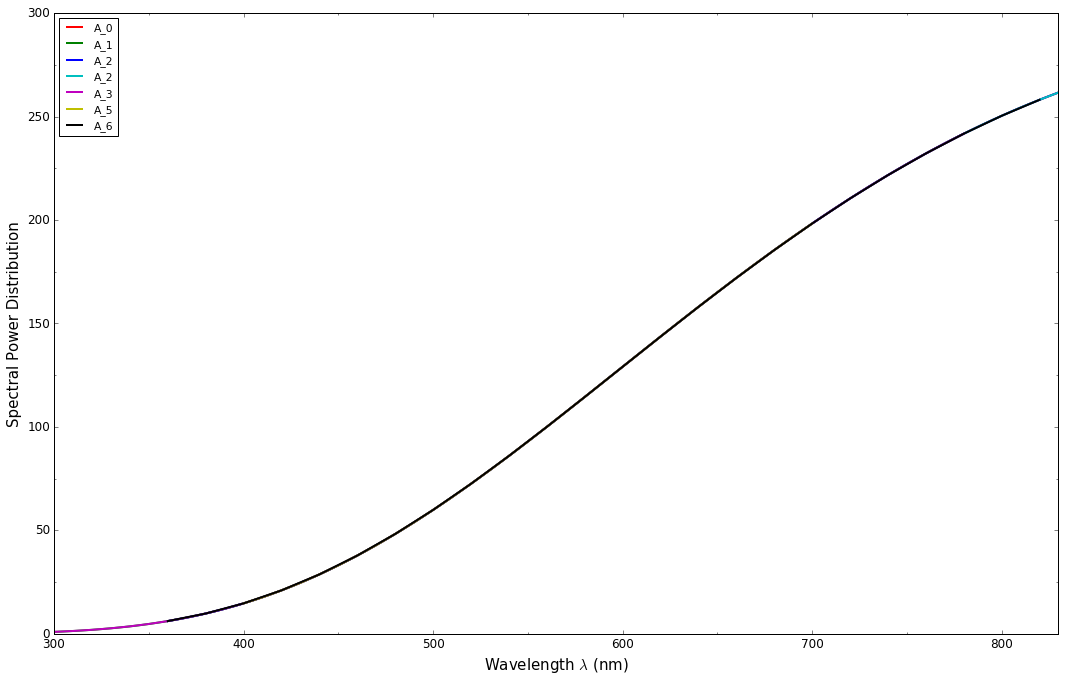

In [2]:
multi_spd_plot(spds)

In [3]:
def tristimulus_weighting_factors_ASTME2022(cmfs, illuminant, shape):
    # Assumes that the measurement interval is equal to the spectral bandwidth integral when applying correction
    # for bandwidth.
    if cmfs.shape.interval != 1:
        raise RuntimeError('"{0}" shape "interval" must be 1!'.format(cmfs))

    if illuminant.shape.interval != 1:
        raise RuntimeError('"{0}" shape "interval" must be 1!'.format(illuminant))

    global _TRISTIMULUS_WEIGHTING_FACTORS_CACHE
    if _TRISTIMULUS_WEIGHTING_FACTORS_CACHE is None:
        _TRISTIMULUS_WEIGHTING_FACTORS_CACHE = CaseInsensitiveMapping()

    name_twf = ', '.join((cmfs.name, illuminant.name, str(shape)))
    if name_twf in _TRISTIMULUS_WEIGHTING_FACTORS_CACHE:
        return _TRISTIMULUS_WEIGHTING_FACTORS_CACHE[name_twf]

    Y = cmfs.values
    S = illuminant.values

    W = S[::shape.interval, np.newaxis] * Y[::shape.interval, :]

    # First and last measurement intervals Lagrange interpolating coefficients.
    c_c = lagrange_interpolating_coefficients_ASTME2022(
            shape.interval, 'boundaries')
    # Intermediate measurement intervals Lagrange interpolating coefficients.
    c_b = lagrange_interpolating_coefficients_ASTME2022(
            shape.interval, 'intermediate')

    # Total wavelengths count.
    w_c = len(Y)
    # Measurement interval interpolated values count.
    r_c = c_b.shape[0]
    # Last interval first interpolated wavelength.
    w_lif = w_c - (w_c - 1) % shape.interval - 1 - r_c

    # Intervals count.
    i_c = W.shape[0]
    i_cm = i_c - 1

    for i in range(3):
        # First interval.
        for j in range(r_c):
            for k in range(3):
                W[k, i] = W[k, i] + c_c[j, k] * S[j + 1] * Y[j + 1, i]

        # Last interval.
        for j in range(r_c):
            for k in range(i_cm, i_cm - 3, -1):
                W[k, i] = (W[k, i] + c_c[r_c - j - 1, i_cm - k] *
                           S[j + w_lif] * Y[j + w_lif, i])

        # Intermediate intervals.
        for j in range(i_c - 3):
            for k in range(r_c):
                w_i = (r_c + 1) * (j + 1) + 1 + k
                W[j, i] = W[j, i] + c_b[k, 0] * S[w_i] * Y[w_i, i]
                W[j + 1, i] = W[j + 1, i] + c_b[k, 1] * S[w_i] * Y[w_i, i]
                W[j + 2, i] = W[j + 2, i] + c_b[k, 2] * S[w_i] * Y[w_i, i]
                W[j + 3, i] = W[j + 3, i] + c_b[k, 3] * S[w_i] * Y[w_i, i]

        # Extrapolation of incomplete interval.
        for j in range(int(w_c - ((w_c - 1) % shape.interval)), w_c, 1):
            W[i_cm, i] = W[i_cm, i] + S[j] * Y[j, i]

    W *= 100 / np.sum(W, axis=0)[1]
    
    _TRISTIMULUS_WEIGHTING_FACTORS_CACHE[name_twf] = W

    return W


interval = 10
W = tristimulus_weighting_factors_ASTME2022(
        CMFS, A_0, SpectralShape(360, 830, interval))
pd.DataFrame(np.round(W, 3), index=CMFS.wavelengths[::interval])

/anaconda/envs/colour-2.7/lib/python2.7/site-packages/ipykernel/__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/envs/colour-2.7/lib/python2.7/site-packages/ipykernel/__main__.py:51: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


,0,1,2
360,-0.000,-0.000,-0.000
370,-0.000,-0.000,-0.000
380,-0.000,-0.000,-0.000
390,0.002,0.000,0.008
400,0.025,0.003,0.110
410,0.134,0.014,0.615
420,0.377,0.039,1.792
430,0.686,0.084,3.386
440,0.964,0.156,4.944
450,1.080,0.259,5.806


In [4]:
print(_TRISTIMULUS_WEIGHTING_FACTORS_CACHE.keys())
print(_TRISTIMULUS_WEIGHTING_FACTORS_CACHE[
    'CIE 1964 10 Degree Standard Observer, A_0, (360.0, 830.0, 10.0)'])

[u'CIE 1964 10 Degree Standard Observer, A_0, (360.0, 830.0, 10.0)']
[[ -0.00000107  -0.00000012  -0.00000472]
 [ -0.00001661  -0.00000178  -0.00007381]
 [ -0.00006265  -0.00000599  -0.00029594]
 [  0.00173203   0.00019067   0.00750329]
 [  0.02462197   0.00258221   0.11002471]
 [  0.13380791   0.01362493   0.61486115]
 [  0.37667958   0.03938975   1.79237892]
 [  0.68597339   0.0841476    3.3861349 ]
 [  0.96392708   0.15560923   4.9435215 ]
 [  1.07974419   0.25937514   5.80554508]
 [  1.00590861   0.42435443   5.81195103]
 [  0.73080637   0.69621402   4.91946293]
 [  0.34300924   1.0820871    3.29990629]
 [  0.07831511   1.61594792   1.97254698]
 [  0.02194756   2.42211921   1.15160362]
 [  0.21833481   3.52935836   0.65817752]
 [  0.74977436   4.83960641   0.38208014]
 [  1.64205871   6.09952855   0.21088813]
 [  2.84155576   7.24966561   0.1017075 ]
 [  4.33599624   8.11420343   0.03166653]
 [  6.19979323   8.75836777   0.00075805]
 [  8.26209852   8.98754929  -0.00039173]
 [ 10.2

In [5]:
def reshape_tristimulus_weighting_factors_ASTME2022(W, shape_W, shape_R):
    W = np.copy(W)

    start_index = int((shape_R.start - shape_W.start) / shape_W.interval)
    for i in range(start_index):
        W[start_index] += W[i]

    end_index = int((shape_W.end - shape_R.end) / shape_W.interval)
    for i in range(end_index):
        W[-end_index - 1] += W[-i - 1]
    
    return W[start_index:-end_index or None, ...]

W = _TRISTIMULUS_WEIGHTING_FACTORS_CACHE[
    'CIE 1964 10 Degree Standard Observer, A_0, (360.0, 830.0, 10.0)']

reshape_tristimulus_weighting_factors_ASTME2022(
        W, SpectralShape(360, 830, 10), SpectralShape(360, 830, 10))

array([[ -0.00000107,  -0.00000012,  -0.00000472],
       [ -0.00001661,  -0.00000178,  -0.00007381],
       [ -0.00006265,  -0.00000599,  -0.00029594],
       [  0.00173203,   0.00019067,   0.00750329],
       [  0.02462197,   0.00258221,   0.11002471],
       [  0.13380791,   0.01362493,   0.61486115],
       [  0.37667958,   0.03938975,   1.79237892],
       [  0.68597339,   0.0841476 ,   3.3861349 ],
       [  0.96392708,   0.15560923,   4.9435215 ],
       [  1.07974419,   0.25937514,   5.80554508],
       [  1.00590861,   0.42435443,   5.81195103],
       [  0.73080637,   0.69621402,   4.91946293],
       [  0.34300924,   1.0820871 ,   3.29990629],
       [  0.07831511,   1.61594792,   1.97254698],
       [  0.02194756,   2.42211921,   1.15160362],
       [  0.21833481,   3.52935836,   0.65817752],
       [  0.74977436,   4.83960641,   0.38208014],
       [  1.64205871,   6.09952855,   0.21088813],
       [  2.84155576,   7.24966561,   0.1017075 ],
       [  4.33599624,   8.11420

In [6]:
def spectral_to_XYZ_integration(
        spd,
        cmfs=STANDARD_OBSERVERS_CMFS.get(
                'CIE 1931 2 Degree Standard Observer'),
        illuminant=ones_spd(STANDARD_OBSERVERS_CMFS.get(
                'CIE 1931 2 Degree Standard Observer').shape)):
    if illuminant.shape != cmfs.shape:
        warning('Aligning "{0}" illuminant shape to '
                '"{1}" colour matching functions shape.'.format(
                illuminant, cmfs))
        illuminant = illuminant.clone().align(cmfs.shape)

    if spd.shape != cmfs.shape:
        warning('Aligning "{0}" spectral power distribution shape to '
                '"{1}" colour matching functions shape.'.format(
                spd, cmfs))
        spd = spd.clone().align(cmfs.shape)

    S = illuminant.values
    x_bar, y_bar, z_bar = tsplit(cmfs.values)
    R = spd.values
    dw = cmfs.shape.interval

    k = 100 / (np.sum(y_bar * S) * dw)

    X_p = R * x_bar * S * dw
    Y_p = R * y_bar * S * dw
    Z_p = R * z_bar * S * dw

    XYZ = k * np.array([np.sum(X_p), np.sum(Y_p), np.sum(Z_p)])

    return XYZ


def spectral_to_XYZ_tristimulus_weighting_factors(
        spd,
        cmfs=STANDARD_OBSERVERS_CMFS.get(
                'CIE 1931 2 Degree Standard Observer'),
        illuminant=ones_spd(STANDARD_OBSERVERS_CMFS.get(
                'CIE 1931 2 Degree Standard Observer').shape)):
    if illuminant.shape != cmfs.shape:
        warning('Aligning "{0}" illuminant shape to '
                '"{1}" colour matching functions shape.'.format(
                illuminant, cmfs))
        illuminant = illuminant.clone().align(cmfs.shape)

    if spd.shape.boundaries != cmfs.shape.boundaries:
        warning('Trimming "{0}" spectral power distribution shape to '
                '"{1}" colour matching functions shape.'.format(
                illuminant, cmfs))
        spd = spd.clone().trim(cmfs.shape)

    W = tristimulus_weighting_factors_ASTME2022(
            cmfs, illuminant, SpectralShape(interval=spd.shape.interval))
    start_w = cmfs.shape.start
    end_w = cmfs.shape.start + spd.shape.interval * (W.shape[0] - 1)
    W = reshape_tristimulus_weighting_factors_ASTME2022(
            W, SpectralShape(start_w, end_w, spd.shape.interval), spd.shape)
    R = spd.values

    XYZ = np.sum(W * R[..., np.newaxis], axis=0)

    return XYZ


def spectral_to_XYZ_ASTM_E30815(
        spd,
        cmfs=STANDARD_OBSERVERS_CMFS.get(
                'CIE 1931 2 Degree Standard Observer'),
        illuminant=ones_spd(
                STANDARD_OBSERVERS_CMFS.get(
                        'CIE 1931 2 Degree Standard Observer').shape),
        im_5nm_omission_method=True,
        im_20nm_abridge_method=True):
    if spd.shape.interval not in (1, 5, 10, 20):
        raise ValueError(
                'Tristimulus values conversion from spectral data following '
                '*ASTM E308-15* designation should be performed on spectral '
                'data with measurement interval of 1, 5, 10 or 20nm!')

    method = spectral_to_XYZ_tristimulus_weighting_factors
    if spd.shape.interval == 1:
        method = spectral_to_XYZ_integration
    elif spd.shape.interval == 5 and im_5nm_omission_method:
        if cmfs.shape.interval != 5:
            cmfs = cmfs.clone().interpolate(SpectralShape(interval=5))
        method = spectral_to_XYZ_integration
    elif spd.shape.interval == 20 and im_20nm_abridge_method:
        spd = spd.clone()
        if spd.shape.boundaries != cmfs.shape.boundaries:
            warning('Trimming "{0}" spectral power distribution shape to '
                    '"{1}" colour matching functions shape.'.format(
                    illuminant, cmfs))
            spd.trim(cmfs.shape)

        # Extrapolation of additional 20nm padding intervals.
        spd.align(SpectralShape(spd.shape.start - 20, spd.shape.end + 20, 10))
        for i in range(2):
            spd[spd.wavelengths[i]] = (3 * spd.values[i + 2] -
                                       3 * spd.values[i + 4] +
                                       spd.values[i + 6])
            i_e = len(spd) - 1 - i
            spd[spd.wavelengths[i_e]] = (spd.values[i_e - 6] -
                                         3 * spd.values[i_e - 4] +
                                         3 * spd.values[i_e - 2])

        # Interpolating every odd numbered values.  
        # TODO: Investigate code vectorisation.         
        for i in range(3, len(spd) - 3, 2):
            spd[spd.wavelengths[i]] = (-0.0625 * spd.values[i - 3] +
                                       0.5625 * spd.values[i - 1] +
                                       0.5625 * spd.values[i + 1] -
                                       0.0625 * spd.values[i + 3])

        # Discarding the additional 20nm padding intervals.       
        spd.trim(SpectralShape(spd.shape.start + 20, spd.shape.end - 20, 10))

    XYZ = method(spd, cmfs, illuminant)

    return XYZ


XYZ_A_0 = spectral_to_XYZ_ASTM_E30815(A_0, CMFS) / 100

for spd in spds:
    print(spd.name)
    print('\tName: {0}'.format(spd.shape))
    XYZ_A_n = spectral_to_XYZ_ASTM_E30815(spd, CMFS) / 100
    print('\tXYZ: {0}'.format(XYZ_A_n))
    print('\tDelta E: {0}'.format(
            colour.delta_E_CIE2000(colour.XYZ_to_Lab(XYZ_A_0),
                                   colour.XYZ_to_Lab(XYZ_A_n))))
    print('\n')

print('\n')

print(_TRISTIMULUS_WEIGHTING_FACTORS_CACHE.keys())

A_0
	Name: (360.0, 830.0, 1.0)
	XYZ: [ 108.41037515   97.54050189   34.33420992]
	Delta E: 0.0


A_1
	Name: (300.0, 780.0, 5.0)
	XYZ: [ 108.41140563   97.54101491   34.33390573]
	Delta E: 0.000643086073379


A_2
	Name: (360.0, 830.0, 5.0)
	XYZ: [ 108.41148545   97.54104514   34.33390262]

/Users/kelsolaar/Documents/Development/colour-science/colour/colour/utilities/verbose.py:128: UserWarning: Aligning "<colour.colorimetry.spectrum.SpectralPowerDistribution object at 0x1091bf690>" illuminant shape to "<colour.colorimetry.cmfs.XYZ_ColourMatchingFunctions object at 0x109106f90>" colour matching functions shape.
  warn(*args, **kwargs)
/Users/kelsolaar/Documents/Development/colour-science/colour/colour/utilities/verbose.py:128: UserWarning: Aligning "<colour.colorimetry.spectrum.SpectralPowerDistribution object at 0x107a9f710>" spectral power distribution shape to "<colour.colorimetry.cmfs.XYZ_ColourMatchingFunctions object at 0x109106f90>" colour matching functions shape.
  warn(*args, **kwargs)
/anaconda/envs/colour-2.7/lib/python2.7/site-packages/ipykernel/__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



	Delta E: 0.000720553331383


A_2
	Name: (360.0, 830.0, 10.0)
	XYZ: [ 108.41037377   97.54050302   34.33426204]
	Delta E: 4.86633069299e-05


A_3
	Name: (300.0, 780.0, 10.0)
	XYZ: [ 108.41030137   97.5404718    34.33426832]
	Delta E: 5.07225469815e-05


A_5
	Name: (400.0, 700.0, 10.0)
	XYZ: [ 108.40204834   97.5371289    34.33618511]
	Delta E: 0.00712222031386


A_6
	Name: (360.0, 820.0, 20.0)
	XYZ: [ 108.41035673   97.54051762   34.33490451]
	Delta E: 0.000646820939847




[u'CIE 1964 10 Degree Standard Observer, A_0, (360.0, 830.0, 10.0)', u'CIE 1964 10 Degree Standard Observer, 1 Constant, (None, None, 10.0)']


/anaconda/envs/colour-2.7/lib/python2.7/site-packages/ipykernel/__main__.py:51: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/kelsolaar/Documents/Development/colour-science/colour/colour/utilities/verbose.py:128: UserWarning: Trimming "<colour.colorimetry.spectrum.SpectralPowerDistribution object at 0x1091bf690>" spectral power distribution shape to "<colour.colorimetry.cmfs.XYZ_ColourMatchingFunctions object at 0x107a8e3d0>" colour matching functions shape.
  warn(*args, **kwargs)
